In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from joblib import load
from tensorflow.keras.models import load_model
from service.ThingsBoardClientLight import ThingsBoardClientLight
from settings.Authentication import Authentication
from service.DataService import DataService

In [3]:
print_ = True
excel = False
fontsize = 14
y_lim = 2.6, 4.1

In [4]:
ds = DataService()
auth = Authentication()
tc = ThingsBoardClientLight(username=auth.USERNAME, api_url=auth.URL, password=auth.PASSWORD)

# variables forecast
window = 24
indicators = 5
horizon = 1

# Laden des trainierten Modells
model = load_model('../../data/model/LGT92_LSTM_model_thesis.h5')

scaler_x = load('../../data/scaler/LGT92_LSTM_scaler_x_thesis.joblib')
scaler_y = load('../../data/scaler/LGT92_LSTM_scaler_y_thesis.joblib')

# telemetry to PandasDataframe
df_325723 = ds.pickle_to_pandas_dataframe('6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce_Thesis_extended_newm_RAW',
                                          ['data_BatV', 'data_rssi', 'data_snr'],
                                          missing_values='lag_impute')
df_325733 = ds.pickle_to_pandas_dataframe('3f394130-a5f9-11ed-8fa7-8d95df41b8ce_Thesis_extended_newm_RAW',
                                          ['data_BatV', 'data_rssi', 'data_snr'],
                                          missing_values='lag_impute')

Metal device set to: Apple M1 Pro


2023-06-20 12:44:38.943292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-20 12:44:38.943414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
print(len(df_325723))

1854


In [5]:
 # create full_curves for given datasets
df_325723_full_curve = ds.create_full_curve_thesis(df_325723, 'data_BatV')

df_325723_full_curve_1 = df_325723.loc[df_325723['data_BatV'].idxmax():].copy()
df_325723_full_curve_1 = df_325723_full_curve_1[20:]
df_325723_full_curve_1 = ds.create_full_curve_thesis(df_325723_full_curve_1, 'data_BatV')

df_325733_full_curve = ds.create_full_curve_thesis(df_325733, 'data_BatV')
df_325733_full_curve_1 = df_325733.loc[df_325733['data_BatV'].idxmax():].copy()
df_325733_full_curve_1 = df_325733_full_curve_1[20:]
df_325733_full_curve_1 = ds.create_full_curve_thesis(df_325733_full_curve_1, 'data_BatV')

In [6]:
# create train set
df_train = pd.concat([df_325723_full_curve, df_325723_full_curve_1, df_325733_full_curve, df_325733_full_curve_1],
                     ignore_index=True)
my_date_range = pd.date_range(end=df_325723.index[-1], periods=len(df_train), freq='H')
df_train['date'] = my_date_range
df_train.set_index('date', inplace=True)
df_train.fillna(0, inplace=True)
df_train.index.freq = 'H'

In [7]:
# NEW TESTSET
df_325744 = ds.pickle_to_pandas_dataframe('fb1c9420-a5f8-11ed-8fa7-8d95df41b8ce_Thesis_extended_RAW',
                                          ['data_BatV', 'data_rssi', 'data_snr'],
                                          missing_values='lag_impute')

df_325744_full_curve = ds.create_full_curve_thesis(df_325744.iloc[:1000], 'data_BatV')
df_325744_full_curve_raw = df_325744.loc[df_325744['data_BatV'].idxmax():].copy()
df_325744_full_curve_1 = ds.create_full_curve_thesis(df_325744_full_curve_raw, 'data_BatV')

df_test = pd.concat([df_325744_full_curve, df_325744_full_curve_1], ignore_index=True)
my_date_range_test = pd.date_range(end=df_325744.index[-1], periods=len(df_test), freq='H')
df_test['date'] = my_date_range_test
df_test.set_index('date', inplace=True)
df_test.fillna(0, inplace=True)
df_test.index.freq = 'H'

# Falsche ID fuer evaluation:
df_test[df_325733['sensor_id'][0]] = 0
df_test[df_325723['sensor_id'][0]] = 1

In [8]:
# train data to time window
X_train_raw = df_train[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values

y_train_raw = df_train[['rm_data_BatV']].values

X_train_std = scaler_x.transform(X_train_raw)
y_train_std = scaler_y.transform(y_train_raw)

# restructure data for LSTM of customTB client
X_train, y_train = ds.restructure_data_for_lstm(X_train_std, y_train_std, window=window, horizon=horizon)

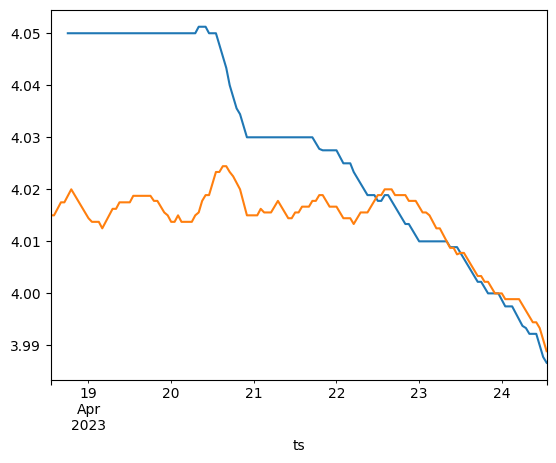

In [9]:
# define Testsets
df_325723_test = df_325723[-140:]
df_325723_test['rm_data_BatV'].plot()
df_325723_test = ds.create_full_curve_thesis(df_325723_test, 'data_BatV', test=True)
df_325733_test = df_325733[-145:]
df_325733_test['rm_data_BatV'].plot()
df_325733_test = ds.create_full_curve_thesis(df_325733_test, 'data_BatV', test=True)
df_325723_test[df_325733_full_curve['sensor_id'][0]] = 0
df_325733_test[df_325723_full_curve['sensor_id'][0]] = 0

In [10]:
# test dataset to time windows 325723
X_test_23_raw = df_325723_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_23_raw = df_325723_test[['rm_data_BatV']].values

X_test_23_std = scaler_x.transform(X_test_23_raw)
y_test_23_std = scaler_y.transform(y_test_23_raw)

X_23_test, y_23_test = ds.restructure_data_for_lstm(X_test_23_std, y_test_23_std, window=window, horizon=horizon)

In [11]:
print(len(X_23_test))

113


In [10]:
# test dataset to time windows 325733
X_test_33_raw = df_325733_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_33_raw = df_325733_test[['rm_data_BatV']].values

X_test_33_std = scaler_x.transform(X_test_33_raw)
y_test_33_std = scaler_y.transform(y_test_33_raw)

X_33_test, y_33_test = ds.restructure_data_for_lstm(X_test_33_std, y_test_33_std, window=window, horizon=horizon)

In [11]:
X_test_44_raw = df_test[
    ['rm_data_BatV', '6aa082d0-a5f8-11ed-8fa7-8d95df41b8ce', '3f394130-a5f9-11ed-8fa7-8d95df41b8ce', 'start',
     'end']].values
y_test_44_raw = df_test[['rm_data_BatV']].values

X_test_44_std = scaler_x.transform(X_test_44_raw)
y_test_44_std = scaler_y.transform(y_test_44_raw)

X_44_test, y_44_test = ds.restructure_data_for_lstm(X_test_44_std, y_test_44_std, window=window, horizon=horizon)

In [19]:
print(len(X_33_test))
print(len(X_23_test))

119
113


In [20]:
# Evaluating the model on test data set X_23_test
y_predict = model.predict(X_23_test)
mae = model.evaluate(X_23_test[:113], y_23_test[:113])
mae_1 = mean_absolute_error(y_test_33_raw[:113], scaler_y.inverse_transform(y_predict))
rmse = np.square(mean_squared_error(y_test_33_raw[:len(y_predict)], scaler_y.inverse_transform(y_predict)))
# Ausgabe der Metriken
print('MAE über die Testdaten: ', mae[1])
print('MAE über die predicted Testdaten: ', mae_1)
print('RMSE über die Testdate: ', rmse)

2023-06-08 17:32:38.749492: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-06-08 17:32:38.971145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 17:32:39.055549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 36ms/step


2023-06-08 17:32:39.188656: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 17:32:39.588581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 17:32:39.642541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-08 17:32:39.720774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 39ms/step - loss: 8.9892e-05 - mae: 0.0073
MAE über die Testdaten:  0.007318356540054083
MAE über die predicted Testdaten:  0.014499373956415904
RMSE über die Testdate:  9.610224957376891e-08


4/4 [==============================] - 0s 10ms/step
Mean Absolute Error for multiple Forecast: 0.01194188328033099
Mean Squad Error for multiple Forecast: 2.838873377082587e-08


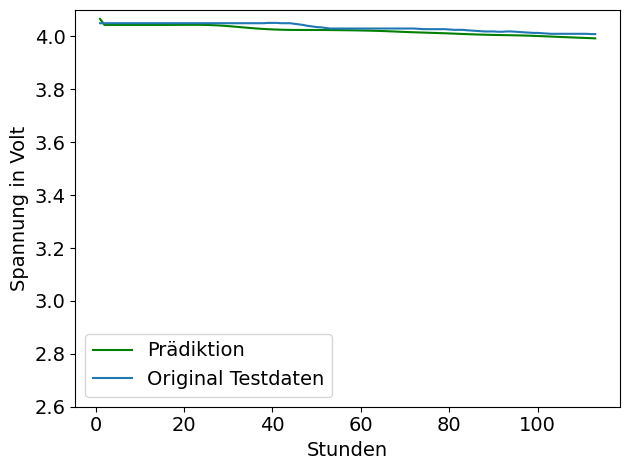

In [18]:
# predict for testdata
y_pred_test = model.predict(X_23_test)
# descale prediction
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test)

# Mean Absolute Error berechnen
mae = mean_absolute_error(y_test_23_raw[:113], scaler_y.inverse_transform(y_pred_test))
rmse = np.square(mean_squared_error(y_test_23_raw[:113], scaler_y.inverse_transform(y_pred_test)))
# print mae & rmse
print("Mean Absolute Error for multiple Forecast:", mae)
print("Mean Squad Error for multiple Forecast:", rmse)

# plot results
plt.plot(np.linspace(1, len(y_pred_test_inv), len(y_pred_test_inv)), y_pred_test_inv, color='green', label='Prädiktion')
plt.plot(np.linspace(1, len(y_test_23_raw[:113]), len(y_test_23_raw[:113])), y_test_23_raw[:113],
         label='Original Testdaten')
plt.ylim(y_lim)
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
if print_:
    plt.savefig(f'../../data/png/evaluate_X_23_test_predict_testdata', pad_inches=2)
plt.show()


1/1 [==============================] - 0s 15ms/step


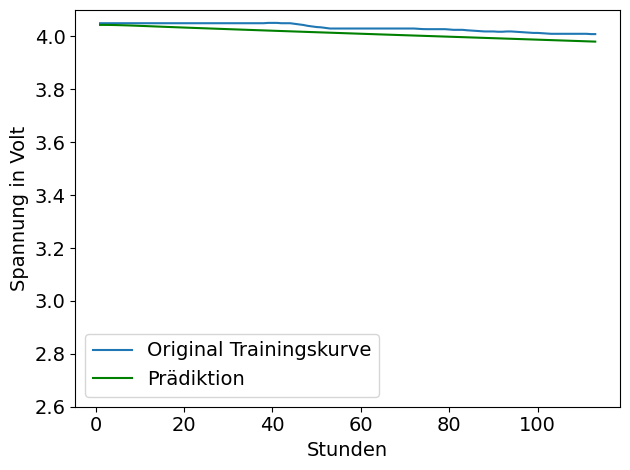

Mean Absolute Error for multiple Forecast: 0.01194188328033099
Root Mean Squad Error for multiple Forecast: 2.838873377082587e-08


In [21]:
# multiple prediction over Testdata 325723
multi_pred_testdata = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                             future_steps=len(X_23_test), model=model, input_data=X_23_test,
                                             scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_23_raw, predicted=multi_pred_testdata, period=len(X_23_test), y_lim=y_lim,
                   window_slot=1, fontsize=14, data_name='multi_pred_testdata')

# Metriks
mae_mptd = mean_absolute_error(y_test_23_raw[:len(multi_pred_testdata)], multi_pred_testdata)
rmse_mptd = np.square(mean_squared_error(y_test_23_raw[:len(multi_pred_testdata)], multi_pred_testdata))
# print results of Metriks
print("Mean Absolute Error for multiple Forecast:", mae)
print("Root Mean Squad Error for multiple Forecast:", rmse)

1/1 [==============================] - 0s 16ms/step


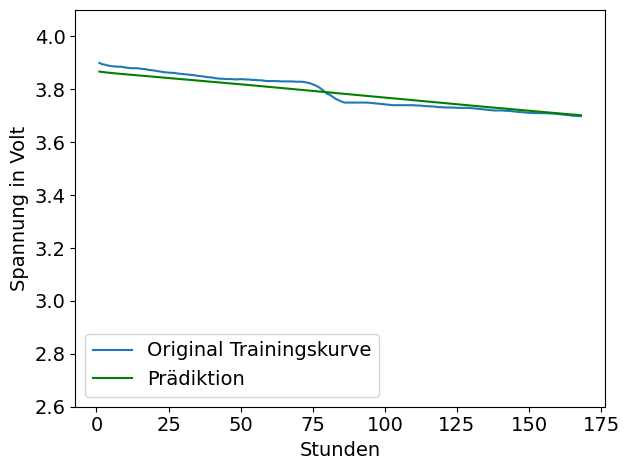

Mean Absolute Error for multiple Forecast: 0.018011874856497977
Root Mean Squad Error for multiple Forecast: 1.5285803665635612e-07


In [22]:
# multiple prediction for one week TRAININGDATA
one_week = 24 * 7
one_week_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=one_week,
                                       model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=one_week_pred, period=one_week, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='one_week')

# calculate Mean Absolute Error
mae_one_week_traindata = mean_absolute_error(y_train_raw[:one_week], one_week_pred)
rmse_one_week_traindata = np.square(mean_squared_error(y_train_raw[:one_week], one_week_pred))
# print reults
print("Mean Absolute Error for multiple Forecast:", mae_one_week_traindata)
print("Root Mean Squad Error for multiple Forecast:", rmse_one_week_traindata)

1/1 [==============================] - 0s 16ms/step


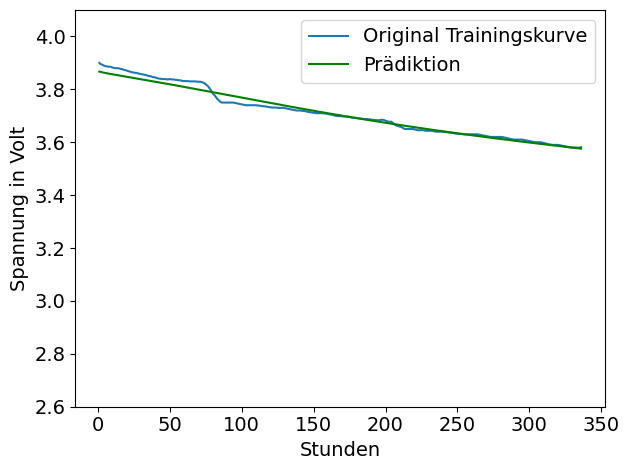

Mean Absolute Error for thee week Forecast on train Data: 0.011121790516981029
Root Mean Squad Error for multiple Forecast: 4.336648740833755e-08


In [23]:
# multiple prediction for two weeks TRAININGDATA
two_weeks = 24 * 7 * 2
two_weeks_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=two_weeks,
                                        model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=two_weeks_pred, period=two_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='two_weeks')

# calculate Mean Absolute Error
mae_two_week_traindata = mean_absolute_error(y_train_raw[:two_weeks], two_weeks_pred)
rmse_two_week_traindata = np.square(mean_squared_error(y_train_raw[:two_weeks], two_weeks_pred))

# print results
print("Mean Absolute Error for thee week Forecast on train Data:", mae_two_week_traindata)
print("Root Mean Squad Error for multiple Forecast:", rmse_two_week_traindata)

1/1 [==============================] - 0s 16ms/step


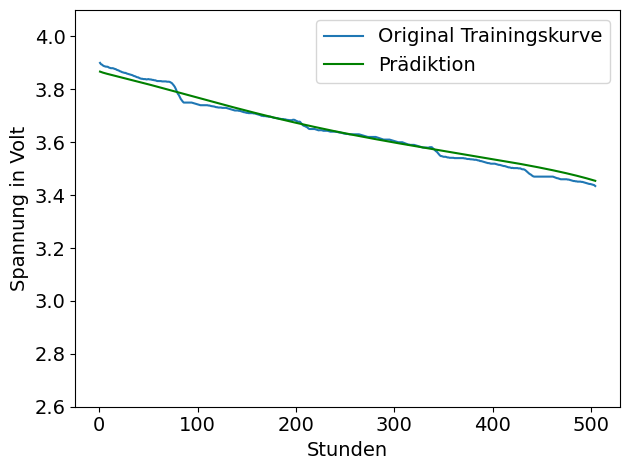

Mean Absolute Error for two week Forecast on train Data: 0.014239799166815373
Root Mean Squad Error for multiple Forecast: 8.586502722231636e-08


In [24]:
# multiple prediction for three weeks TRAININGDATA
three_weeks = 24 * 7 * 3
three_weeks_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=three_weeks,
                                          model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=three_weeks_pred, period=three_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='three_weeks')

# calculate Mean Absolute Error
mae_three_week_traindata = mean_absolute_error(y_train_raw[:three_weeks], three_weeks_pred)
rmse_three_week_traindata = np.square(mean_squared_error(y_train_raw[:three_weeks], three_weeks_pred))

# print results
print("Mean Absolute Error for two week Forecast on train Data:", mae_three_week_traindata)
print("Root Mean Squad Error for multiple Forecast:", rmse_three_week_traindata)

1/1 [==============================] - 0s 16ms/step


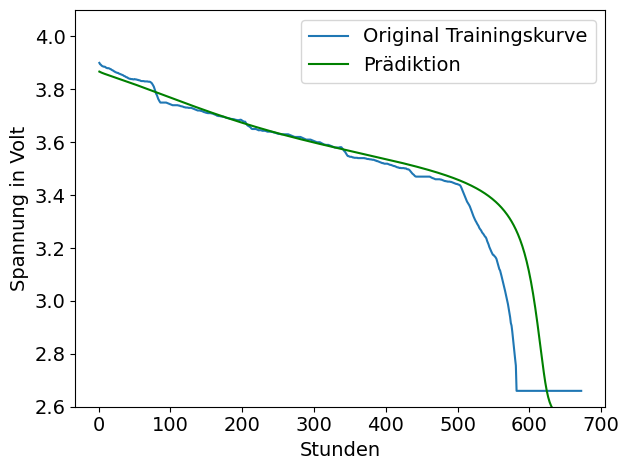

Mean Absolute Error for two week Forecast on train Data: 0.06306592860388315
Root Mean Squad Error for multiple Forecast: 0.00030854001395307047


In [25]:
# multiple prediction for four weeks TRAININGDATA
four_weeks = 24 * 7 * 4
four_weeks_pred = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=four_weeks,
                                         model=model, input_data=X_train, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_train_raw, predicted=four_weeks_pred, period=four_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='four_weeks')

# calculate Mean Absolute Error
mae_four_week_traindata = mean_absolute_error(y_train_raw[:four_weeks], four_weeks_pred)
rmse_four_week_traindata = np.square(mean_squared_error(y_train_raw[:four_weeks], four_weeks_pred))

# print results
print("Mean Absolute Error for two week Forecast on train Data:", mae_four_week_traindata)
print("Root Mean Squad Error for multiple Forecast:", rmse_four_week_traindata)

In [26]:
# multiple predictions second curve
four_weeks = 24 * 7 * 4
four_weeks_pred_k2 = ds.multiple_prediction(window_slot=3400, window=window, indicators=indicators,
                                            future_steps=four_weeks, model=model, input_data=X_train, scaler=scaler_y)

# calculate Mean Absolute Error
mae_four_week_k2_traindata = mean_absolute_error(y_train_raw[:four_weeks], four_weeks_pred_k2)
rmse_four_week_k2_traindata = np.square(mean_squared_error(y_train_raw[:four_weeks], four_weeks_pred_k2))

# print results
print("Mean Absolute Error for four week Forecast on train Data:", mae_four_week_k2_traindata)
print("Root Mean Squad Error for multiple Forecast:", rmse_four_week_k2_traindata)

1/1 [==============================] - 0s 17ms/step
Mean Absolute Error for four week Forecast on train Data: 0.4921945490457256
Root Mean Squad Error for multiple Forecast: 0.12155380349509734


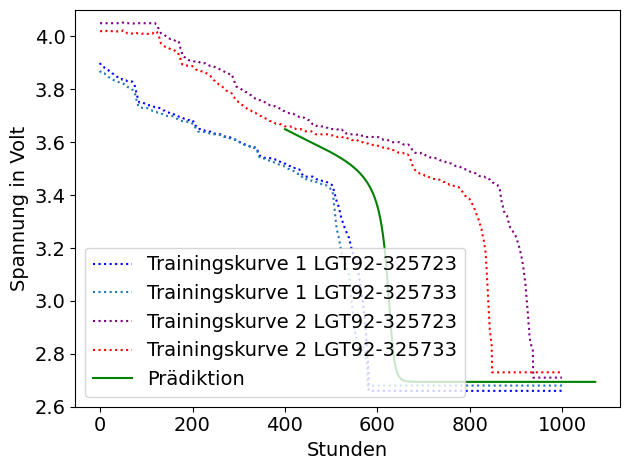

In [27]:
# plot results
df_325723_full_curve['rm_data_BatV'].plot(color='blue', linestyle='dotted', label='Trainingskurve 1 LGT92-325723')
df_325733_full_curve['rm_data_BatV'].plot(linestyle='dotted', label='Trainingskurve 1 LGT92-325733')
df_325723_full_curve_1['rm_data_BatV'].plot(color='purple', linestyle='dotted', label='Trainingskurve 2 LGT92-325723')
df_325733_full_curve_1['rm_data_BatV'].plot(color='red', linestyle='dotted', label='Trainingskurve 2 LGT92-325733')
plt.plot(np.arange(400, 400 + len(four_weeks_pred_k2)),
         four_weeks_pred_k2, label='Prädiktion', color='green')
plt.legend()
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.ylim(y_lim)
plt.tight_layout()
save = plt.savefig(f'../../data/png/evaluate_train_predict_future_2k', pad_inches=2)
plt.show()

In [28]:
# Generiere Vorhersagen TESDATENSATZ 23
where = -1
future_steps = 24 * 7 * 4
x_test = X_23_test[where]
current_input = x_test
print(f'Erster input: {current_input}')
y_test_future = np.zeros((future_steps,))
for i in range(future_steps):
    current_input = np.reshape(current_input, (1, window, indicators))
    y_test_future[i] = model.predict(current_input)
    print(f'Aktuelle Vorhersage{y_test_future[i]}')
    current_input = np.insert(current_input, window,
                              (y_test_future[i], x_test[0][1], x_test[0][2], x_test[0][3], x_test[0][4]), axis=1)
    print(current_input)
    current_input = np.delete(current_input, 0, axis=1)
    print(f'Input runde {i}: {current_input}')


Erster input: [[ 1.3170558   1.         -1.         -0.0316386  -0.59852677]
 [ 1.3170558   1.         -1.         -0.0316386  -0.59852677]
 [ 1.31469392  1.         -1.         -0.0316386  -0.59852677]
 [ 1.31233203  1.         -1.         -0.0316386  -0.59852677]
 [ 1.30997015  1.         -1.         -0.0316386  -0.59852677]
 [ 1.30760827  1.         -1.         -0.0316386  -0.59852677]
 [ 1.30524638  1.         -1.         -0.0316386  -0.59852677]
 [ 1.3028845   1.         -1.         -0.0316386  -0.59852677]
 [ 1.3028845   1.         -1.         -0.0316386  -0.59852677]
 [ 1.30052262  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29816074  1.         -1.         -0.0316386  -0.59852677]
 [ 1.29550362  1.         -1.         -0.0316386  -0.59852677]
 [ 1.2928465   1.         -1.         -0.

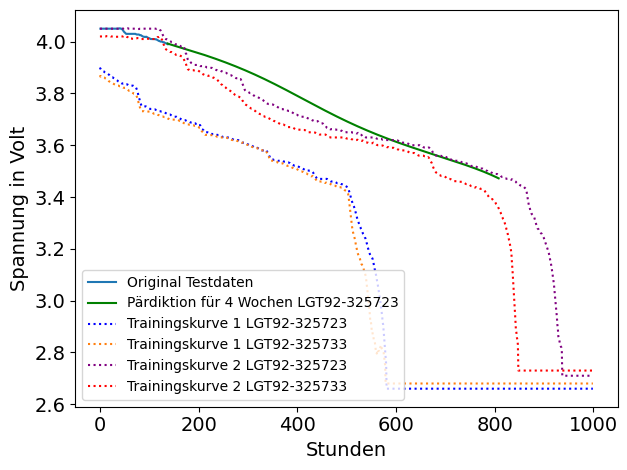

In [29]:
to_descale = np.reshape(y_test_future, (-1, 1))
plt.plot(np.linspace(1, len(y_test_23_raw), len(y_test_23_raw)), y_test_23_raw, label='Original Testdaten')
plt.plot(np.arange(len(X_23_test) + window, len(X_23_test) + window + len(to_descale)),
         scaler_y.inverse_transform(to_descale), label='Pärdiktion für 4 Wochen LGT92-325723', color='green')
df_325723_full_curve['rm_data_BatV'].plot(color='blue', linestyle='dotted', label='Trainingskurve 1 LGT92-325723')
df_325733_full_curve['rm_data_BatV'].plot(linestyle='dotted', label='Trainingskurve 1 LGT92-325733')
df_325723_full_curve_1['rm_data_BatV'].plot(color='purple', linestyle='dotted', label='Trainingskurve 2 LGT92-325723')
df_325733_full_curve_1['rm_data_BatV'].plot(color='red', linestyle='dotted', label='Trainingskurve 2 LGT92-325733')
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.legend()
plt.tight_layout()
if print_:
    plt.savefig(f'../../data/png/evaluate_test_predict_future_Sensor23', pad_inches=2)
plt.show()

In [30]:
# Generiere Vorhersagen TESTDATEN 33
where = -1
future_steps = 24 * 7 * 4
x_test = X_33_test[where]
current_input = x_test
print(f'Erster input: {current_input}')
y_test_future = np.zeros((future_steps,))
for i in range(future_steps):
    current_input = np.reshape(current_input, (1, window, indicators))
    y_test_future[i] = model.predict(current_input)
    print(f'Aktuelle Vorhersage{y_test_future[i]}')
    current_input = np.insert(current_input, window,
                              (y_test_future[i], x_test[0][1], x_test[0][2], x_test[0][3], x_test[0][4]), axis=1)
    print(current_input)
    current_input = np.delete(current_input, 0, axis=1)
    print(f'Input runde {i}: {current_input}')

Erster input: [[ 1.31410344 -1.          1.         -0.0316386  -0.59852677]
 [ 1.31469392 -1.          1.         -0.0316386  -0.59852677]
 [ 1.31469392 -1.          1.         -0.0316386  -0.59852677]
 [ 1.31233203 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30997015 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30760827 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30524638 -1.          1.         -0.0316386  -0.59852677]
 [ 1.30524638 -1.          1.         -0.0316386  -0.59852677]
 [ 1.3028845  -1.          1.         -0.0316386  -0.59852677]
 [ 1.3028845  -1.          1.         -0.0316386  -0.59852677]
 [ 1.30052262 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29816074 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29816074 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29816074 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29579885 -1.          1.         -0.0316386  -0.59852677]
 [ 1.29579885 -1.          1.         -0.

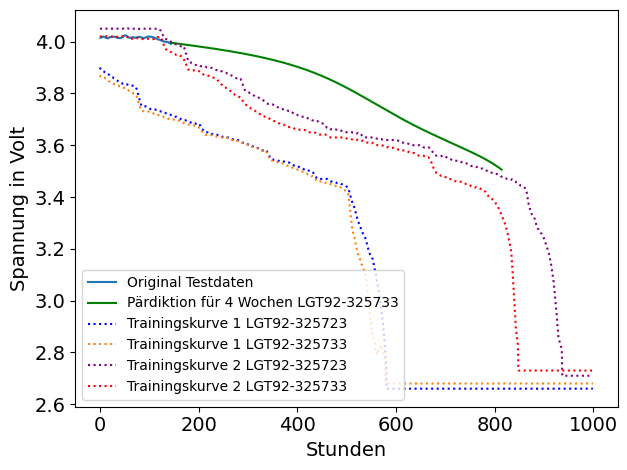

In [31]:
to_descale = np.reshape(y_test_future, (-1, 1))
plt.plot(np.linspace(1, len(y_test_33_raw), len(y_test_33_raw)), y_test_33_raw, label='Original Testdaten')
plt.plot(np.arange(len(X_33_test) + window, len(X_33_test) + window + len(to_descale)),
         scaler_y.inverse_transform(to_descale), label='Pärdiktion für 4 Wochen LGT92-325733', color='green')
df_325723_full_curve['rm_data_BatV'].plot(color='blue', linestyle='dotted', label='Trainingskurve 1 LGT92-325723')
df_325733_full_curve['rm_data_BatV'].plot(linestyle='dotted', label='Trainingskurve 1 LGT92-325733')
df_325723_full_curve_1['rm_data_BatV'].plot(color='purple', linestyle='dotted', label='Trainingskurve 2 LGT92-325723')
df_325733_full_curve_1['rm_data_BatV'].plot(color='red', linestyle='dotted', label='Trainingskurve 2 LGT92-325733')
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.legend()
plt.tight_layout()
if print_:
    plt.savefig(f'../../data/png/evaluate_test_predict_future_Sensor33', pad_inches=2)
plt.show()

1/1 [==============================] - 0s 16ms/step


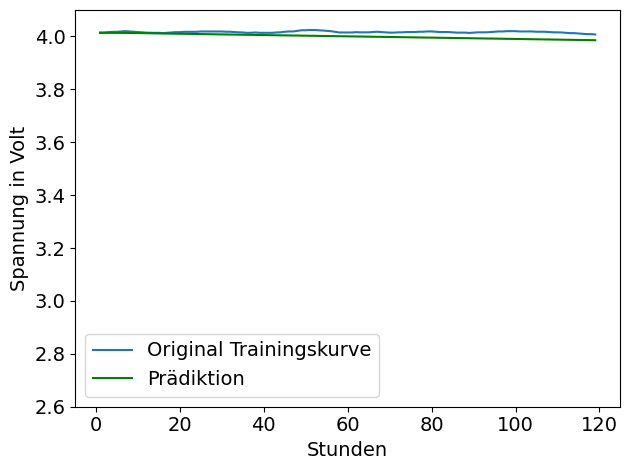

Mean Absolute Error for multiple Forecast: 0.016231054373570555
Root Mean Squad Error for multiple Forecast: 1.1114969685522294e-07


In [32]:
# multiple prediction over Testdata 325733
multi_pred_testdata_33 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                                future_steps=len(X_33_test), model=model, input_data=X_33_test,
                                                scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_33_raw, predicted=multi_pred_testdata_33, period=len(X_33_test), y_lim=y_lim,
                   window_slot=1, fontsize=14, data_name='multi_pred_testdata_33')

# Metriks
mae_mptd_33 = mean_absolute_error(y_test_33_raw[:len(multi_pred_testdata_33)], multi_pred_testdata_33)
rmse_mptd_33 = np.square(mean_squared_error(y_test_33_raw[:len(multi_pred_testdata_33)], multi_pred_testdata_33))
# print results of Metriks
print("Mean Absolute Error for multiple Forecast:", mae_mptd_33)
print("Root Mean Squad Error for multiple Forecast:", rmse_mptd_33)

RMSE über die Testdate:  2.838873377082587e-08
4/4 [==============================] - 0s 40ms/step
Mean Absolute Error for multiple Forecast: 0.014499373956415904
Mean Squad Error for multiple Forecast: 9.610224957376891e-08


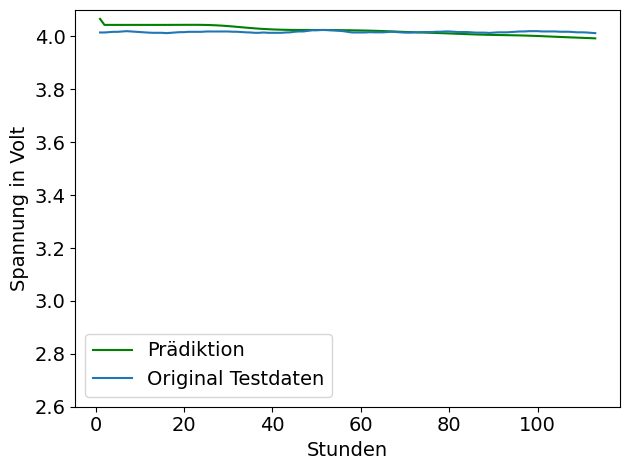

In [33]:
## Evaluation über X_33 TEST

print('RMSE über die Testdate: ', rmse)
# predict for testdata
y_pred_test_33 = model.predict(X_33_test)
# descale prediction
y_pred_test_inv_33 = scaler_y.inverse_transform(y_pred_test)

# Mean Absolute Error berechnen
mae = mean_absolute_error(y_test_33_raw[:len(y_pred_test_inv_33)], y_pred_test_inv_33)
rmse = np.square(mean_squared_error(y_test_33_raw[:len(y_pred_test_inv_33)], y_pred_test_inv_33))
# print mae & rmse
print("Mean Absolute Error for multiple Forecast:", mae)
print("Mean Squad Error for multiple Forecast:", rmse)

# plot results
plt.plot(np.linspace(1, len(y_pred_test_inv_33), len(y_pred_test_inv_33)), y_pred_test_inv_33, color='green',
         label='Prädiktion')
plt.plot(np.linspace(1, len(y_test_33_raw[:len(y_pred_test_inv_33)]), len(y_pred_test_inv_33)),
         y_test_33_raw[:len(y_pred_test_inv)],
         label='Original Testdaten')
plt.ylim(y_lim)
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
if print_:
    plt.savefig(f'../../data/png/evaluate_test_predict_testdata_33', pad_inches=2)
plt.show()

# Evaluate on LGT92-3579244

1/1 [==============================] - 0s 17ms/step


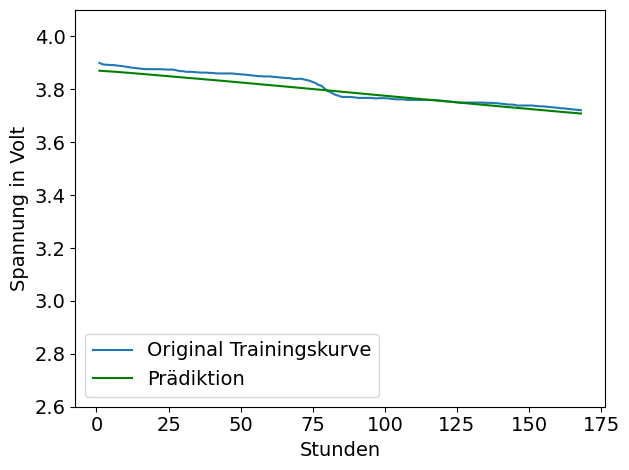

Mean Absolute Error for multiple Forecast: 0.01738954153338753
Root Mean Squad Error for multiple Forecast: 1.592045674245125e-07


In [34]:
# multiple prediction for one week LG92-44
one_week = 24 * 7
one_week_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=one_week,
                                          model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=one_week_pred_44, period=one_week, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='one_week_Sensor_44')

# calculate Mean Absolute Error
mae_one_week_traindata_44 = mean_absolute_error(y_test_44_raw[:one_week], one_week_pred_44)
rmse_one_week_traindata_44 = np.square(mean_squared_error(y_test_44_raw[:one_week], one_week_pred_44))
# print reults
print("Mean Absolute Error for multiple Forecast:", mae_one_week_traindata_44)
print("Root Mean Squad Error for multiple Forecast:", rmse_one_week_traindata_44)


1/1 [==============================] - 0s 17ms/step


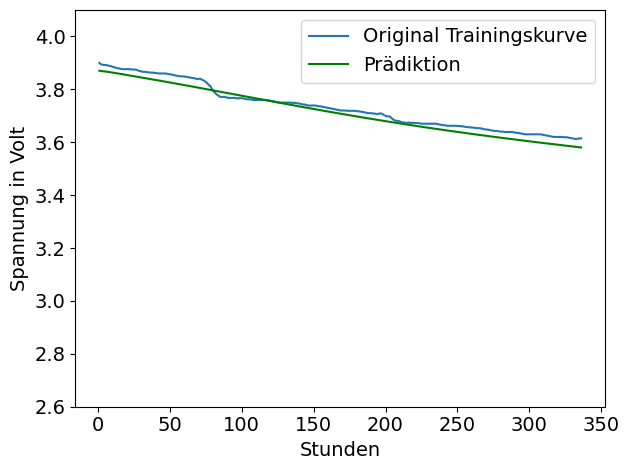

Mean Absolute Error for multiple Forecast: 0.019592699597335977
Root Mean Squad Error for multiple Forecast: 2.1173152307265766e-07


In [35]:
# multiple prediction for one week LG92-44
two_weeks = 24 * 7 * 2
two_weeks_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators, future_steps=two_weeks,
                                           model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=two_weeks_pred_44, period=two_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='two_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_two_week_traindata_44 = mean_absolute_error(y_test_44_raw[:two_weeks], two_weeks_pred_44)
rmsetwo_week_traindata_44 = np.square(mean_squared_error(y_test_44_raw[:two_weeks], two_weeks_pred_44))
# print reults
print("Mean Absolute Error for multiple Forecast:", mae_two_week_traindata_44)
print("Root Mean Squad Error for multiple Forecast:", rmsetwo_week_traindata_44)

1/1 [==============================] - 0s 17ms/step


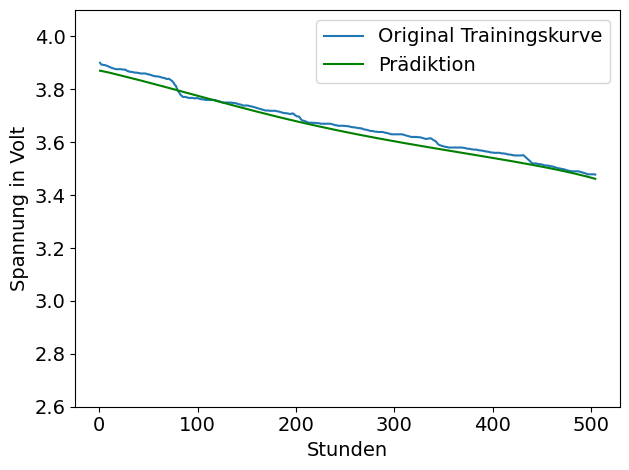

Mean Absolute Error for multiple Forecast: 0.018379992605839775
Root Mean Squad Error for multiple Forecast: 1.671041439066649e-07


In [36]:
# multiple prediction for one week LG92-44
three_weeks = 24 * 7 * 3
three_weeks_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                             future_steps=three_weeks,
                                             model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=three_weeks_pred_44, period=three_weeks, y_lim=y_lim, window_slot=1,
                   fontsize=fontsize, data_name='three_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_three_week_testdata_44 = mean_absolute_error(y_test_44_raw[:three_weeks], three_weeks_pred_44)
rmse_three_week_testdata_44 = np.square(mean_squared_error(y_test_44_raw[:three_weeks], three_weeks_pred_44))
# print reults
print("Mean Absolute Error for multiple Forecast:", mae_three_week_testdata_44)
print("Root Mean Squad Error for multiple Forecast:", rmse_three_week_testdata_44)

1/1 [==============================] - 0s 16ms/step


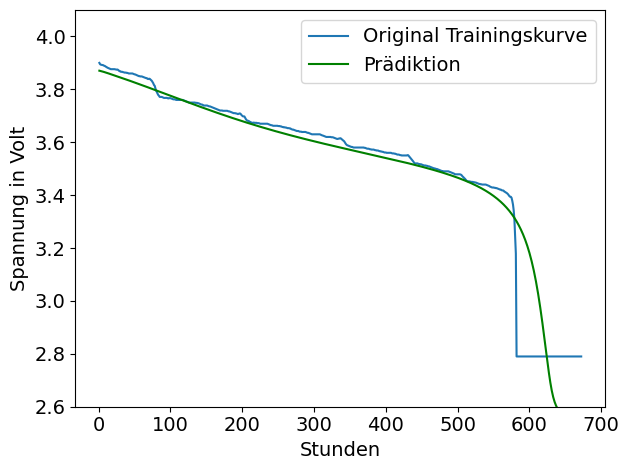

Mean Absolute Error for multiple Forecast: 0.05152760002113087
Root Mean Squad Error for multiple Forecast: 0.000131064059176395


In [37]:
# multiple prediction for one week LG92-44
four_weeks = 24 * 7 * 4
four_weeks_pred_44 = ds.multiple_prediction(window_slot=1, window=window, indicators=indicators,
                                            future_steps=four_weeks,
                                            model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=four_weeks_pred_44, period=four_weeks, y_lim=y_lim,
                   window_slot=1,
                   fontsize=fontsize, data_name='four_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_four_week_testdata_44 = mean_absolute_error(y_test_44_raw[:four_weeks], four_weeks_pred_44)
rmse_four_week_testdata_44 = np.square(mean_squared_error(y_test_44_raw[:four_weeks], four_weeks_pred_44))
# print reults
print("Mean Absolute Error for multiple Forecast:", mae_four_week_testdata_44)
print("Root Mean Squad Error for multiple Forecast:", rmse_four_week_testdata_44)

1/1 [==============================] - 0s 18ms/step


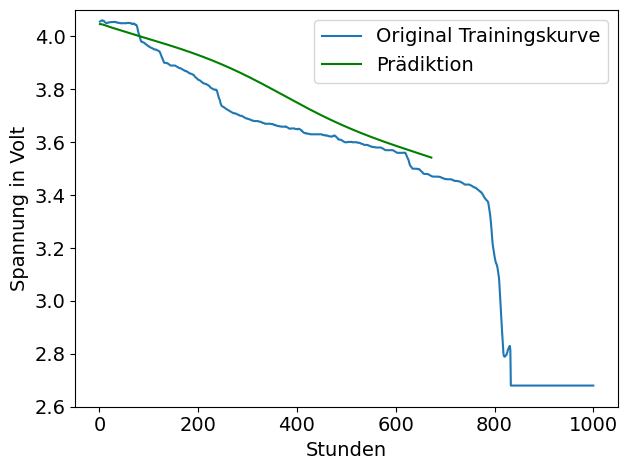

Mean Absolute Error for multiple Forecast: 0.07511084022938107
Root Mean Squad Error for multiple Forecast: 5.980999714743509e-05


In [29]:
# multiple prediction for one week LG92-44
four_weeks = 24 * 7 * 4
four_weeks_pred_44_curve_2 = ds.multiple_prediction(window_slot=1001, window=window, indicators=indicators,
                                            future_steps=four_weeks,
                                            model=model, input_data=X_44_test, scaler=scaler_y)

# plot results
ds.plot_multi_pred(y_raw=y_test_44_raw, predicted=four_weeks_pred_44_curve_2, period=1000, y_lim=y_lim,
                   window_slot=1, offset=1000,
                   fontsize=fontsize, data_name='four_weeks_Sensor_44')

# calculate Mean Absolute Error
mae_four_week_testdata_44_curve_2 = mean_absolute_error(y_test_44_raw[1000:1000 + four_weeks], four_weeks_pred_44_curve_2)
rmse_four_week_testdata_44_curve_2 = np.square(mean_squared_error(y_test_44_raw[1000: 1000 + four_weeks], four_weeks_pred_44_curve_2))
# print reults
print("Mean Absolute Error for multiple Forecast:", mae_four_week_testdata_44_curve_2)
print("Root Mean Squad Error for multiple Forecast:", rmse_four_week_testdata_44_curve_2)

62/62 [==============================] - 1s 9ms/step
Mean Absolute Error for multiple Forecast: 0.0680932811850191
Mean Squad Error for multiple Forecast: 0.0007702570405561243


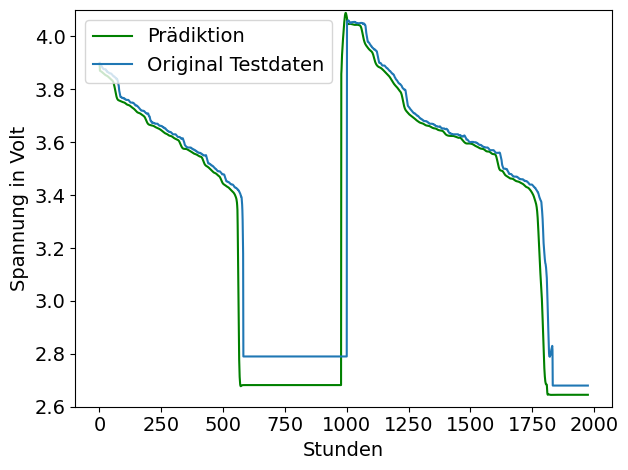

In [38]:
# predict for testdata
y_pred_test = model.predict(X_44_test)
# descale prediction
y_pred_test_inv = scaler_y.inverse_transform(y_pred_test)

# Mean Absolute Error berechnen
mae = mean_absolute_error(y_test_44_raw[:len(y_pred_test)], scaler_y.inverse_transform(y_pred_test))
rmse = np.square(mean_squared_error(y_test_44_raw[:len(y_pred_test)], scaler_y.inverse_transform(y_pred_test)))
# print mae & rmse
print("Mean Absolute Error for multiple Forecast:", mae)
print("Mean Squad Error for multiple Forecast:", rmse)

# plot results
plt.plot(np.linspace(1, len(y_pred_test_inv), len(y_pred_test_inv)), y_pred_test_inv, color='green', label='Prädiktion')
plt.plot(np.linspace(1, len(y_test_44_raw[:len(y_pred_test)]), len(y_test_44_raw[:len(y_pred_test)])),
         y_test_44_raw[:len(y_pred_test)], label='Original Testdaten')
plt.ylim(y_lim)
plt.xlabel('Stunden', fontsize=fontsize)
plt.ylabel('Spannung in Volt', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.tight_layout()
if print_:
    plt.savefig(f'../../data/png/evaluate_test_predict_testdata_44', pad_inches=2)
plt.show()